# Final Project

Goals
* Box + vanishing point -> 3D image
* Manual detection of box?
```
───────────────────────────────────────
───▐▀▄───────▄▀▌───▄▄▄▄▄▄▄─────────────
───▌▒▒▀▄▄▄▄▄▀▒▒▐▄▀▀▒██▒██▒▀▀▄──────────
──▐▒▒▒▒▀▒▀▒▀▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▀▄────────
──▌▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▄▒▒▒▒▒▒▒▒▒▒▒▒▀▄──────
▀█▒▒▒█▌▒▒█▒▒▐█▒▒▒▀▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▌─────
▀▌▒▒▒▒▒▒▀▒▀▒▒▒▒▒▒▀▀▒▒▒▒▒▒▒▒▒▒▒▒▒▒▐───▄▄
▐▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▌▄█▒█
▐▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒█▒█▀─
▐▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒█▀───
▐▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▌────
─▌▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▐─────
─▐▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▌─────
──▌▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▐──────
──▐▄▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▄▌──────
────▀▄▄▀▀▀▀▀▄▄▀▀▀▀▀▀▀▄▄▀▀▀▀▀▄▄▀────────
```

## Setup

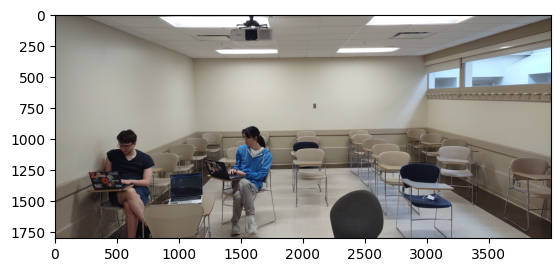

In [148]:
import numpy as np
import numpy.linalg as la
import cv2
import matplotlib.pyplot as plt
import numpy.linalg as linalg

import utils

image = cv2.imread("./pictures/trial_room.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
from utils.io import read_image, write_image, read_hdr_image, write_hdr_image
from utils.display import display_images_linear_rescale, rescale_images_linear
from utils.hdr_helpers import gsolve
from utils.hdr_helpers import get_equirectangular_image
from utils.bilateral_filter import bilateral_filter

plt.imshow(image_rgb)
plt.show()

### Back wall + vanishing point 

In [270]:
# box coordinates

box = np.array( # Trial Room
    [[(1113,  356), (2987,  356)],
     [(1113, 1224), (2987, 1224)] ]
)

# vanishing point the image is a bit offcenter
vp = np.array((1906, 643))


width_box  = np.average(box[:,1,0] - box[:,0,0])
height_box = np.average(box[1,:,1] - box[0,:,1])

height_image = len(image_rgb)
width_image = len(image_rgb[0])

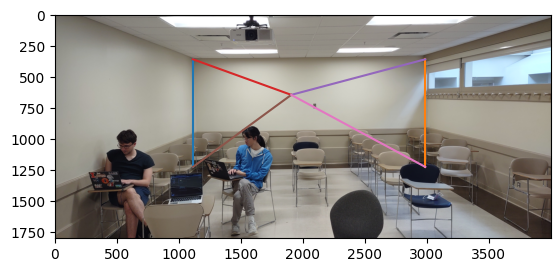

In [288]:
# display
plt.plot(box[...,0], box[...,1])
plt.plot(vp[0], vp[1])
for (x, y) in box.reshape(-1, 2):
    plt.plot([vp[0], x], [vp[1], y])
plt.imshow(image_rgb)

### Depth

In [ ]:
# Computing Depth

fstop = 1.7
focal_length_mm = 5 # TODO use package to auto import from images
aperture_diameter_mm = focal_length_mm / fstop

# bottom = np.average([box[1,0], box[1,1]])
# # dv = vp[1] - bottom

# # compute dimensions of box
# # f / (va - v0) = d / H
# depth = focal_length_mm * height_box / (aperture_diameter_mm / 2)
# print(depth) 

half_aperature = aperture_diameter_mm / 2

# Compute half of the image
half_image = height_image /2

# Compute half of the backwall
half_back_wall = height_box / 2

# Solve for the va - v0 value 
va_minus_vo = half_aperature * half_back_wall / half_image




# Use similar Triangles to compute the Depth

height_vanishing = box[1][1][1] - vp[1]
print(height_vanishing)

depth_image = focal_length_mm * height_vanishing / (va_minus_vo)
depth_image = int(depth_image)

581


### Homography

#### Box for each wall

wall_corners
 [[[   0  -46]
  [4000   87]]

 [[   0 2039]
  [4000 1768]]]


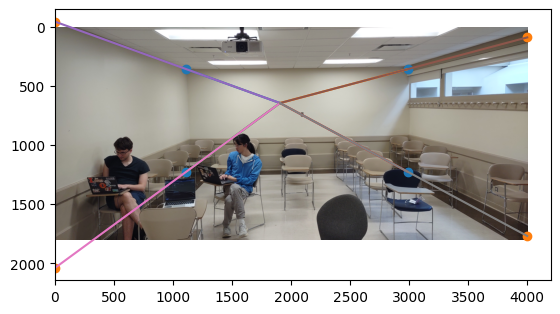

plane_corners
 [[[ 129    0]
  [4327    0]]

 [[ 326 1800]
  [4058 1800]]]


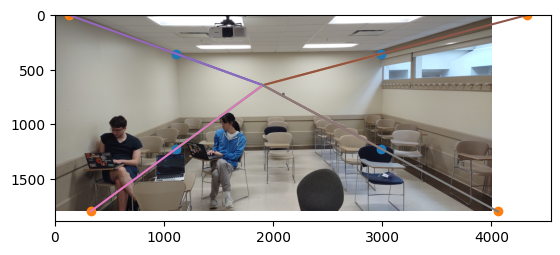

In [ ]:
# extend each edge so that it goes beyond the image
wall_edge_vectors = box - vp  # (2, 2, 2) # everything is x,y except when we have to convert to and from image
# wall_edge_vectors = (wall_edge_vectors / np.max(wall_edge_vectors))
image_corners = np.array([[[0, 0], [width_image, 0]],
                          [[0,height_image], [width_image, height_image]] ])
vp_to_image_corners = image_corners - vp # (2, 2, 2)
scale_factors = vp_to_image_corners / wall_edge_vectors # (2, 2, 2)
x_scale_factors, y_scale_factors = scale_factors[..., 0], scale_factors[..., 1]
assert x_scale_factors.shape == (2, 2), x_scale_factors.shape
assert y_scale_factors.shape == (2, 2), y_scale_factors.shape
wall_corners = wall_edge_vectors * x_scale_factors[..., np.newaxis] + vp
plane_corners = wall_edge_vectors * y_scale_factors[..., np.newaxis] + vp


plt.imshow(image_rgb)

print("wall_corners\n", wall_corners.astype('int'))

for (x, y) in box.reshape((-1,2)):
    plt.plot([vp[0], x], [vp[1], y])
for (x, y) in wall_corners.reshape((-1,2)):
    plt.plot([vp[0], x], [vp[1], y])
plt.scatter(box[..., 0], box[..., 1])
plt.scatter(wall_corners[..., 0], wall_corners[..., 1])
plt.show()



plt.imshow(image_rgb)

print("plane_corners\n", plane_corners.astype('int'))

for (x, y) in box.reshape((-1,2)):
    plt.plot([vp[0], x], [vp[1], y])
for (x, y) in plane_corners.reshape((-1,2)):
    plt.plot([vp[0], x], [vp[1], y])
plt.scatter(box[..., 0], box[..., 1])
plt.scatter(plane_corners[..., 0], plane_corners[..., 1])
plt.show()

In [344]:
box_lengths = la.norm(wall_corners - box, axis=-1)

print(box)
print(wall_corners)
print(box_lengths)


left_box = np.stack([wall_corners[:,0], box[:,0]], axis=1)
right_box = np.stack([box[:,1], wall_corners[:, 1]], axis=1)
top_box = np.stack([plane_corners[0,:], box[0,:]], axis=0)
bottom_box = np.stack([box[1,:], plane_corners[1,:]], axis=0)

[[[1113  356]
  [2987  356]]

 [[1113 1224]
  [2987 1224]]]
[[[ 2.27373675e-13 -4.68133670e+01]
  [ 4.00000000e+03  8.70536540e+01]]

 [[ 2.27373675e-13  2.03945145e+03]
  [ 4.00000000e+03  1.76845236e+03]]]
[[1183.65012086 1048.0940497 ]
 [1379.75724952 1150.0423345 ]]


In [341]:
def plot_box(box):
    pts = np.array([box[0,0], box[1,0], box[1,1], box[0,1],box[0,0]])
    plt.plot(pts[:,0], pts[:,1])

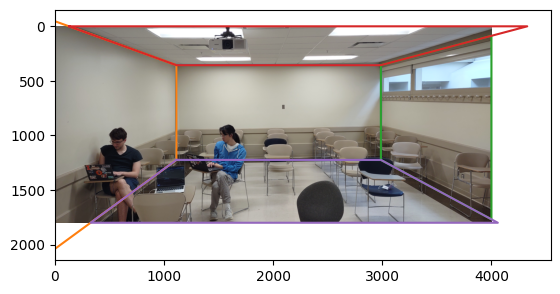

In [342]:
plt.imshow(image_rgb)
plot_box(box)
plot_box(left_box)
plot_box(right_box)
plot_box(top_box)
plot_box(bottom_box)

In [345]:
# fov = 2 * np.arctan(depth/(2 * focal_length_mm)) # angle
# compute visible depth, i.e. depth of the edge where the wall meets the floor (or where the wall meets the ceiling)
tan_fov = (aperture_diameter_mm/2) / focal_length_mm

camera_height = vp[0] - box
hidden_depth = 1/tan_fov * camera_height
visible_depth = depth_image - hidden_depth

camera_distances_to_edge = la.norm(box - vp, axis = -1) # == vp distance to corner
hidden_depths = 1/tan_fov * camera_distances_to_edge
visible_depths = depth_image - hidden_depths

In [346]:
print(visible_depths)

[[1228.65278001  293.27061178]
 [ 753.59074918  -76.6215165 ]]


In [ ]:
def computeHomography(top, bottom, height, depth):
    '''
    Compute homography for wall/floor/ceiling.
    
    - top: 2 points
    - bottom: 2 points
    - height: height
    - depth: depth / length of the box face
    '''
    # TO DO
    # create A
    A = np.zeros((8, 9))
    
    # TOP LEFT
    u = top[0,0]
    v = top[0,1]

    u_prime = 0
    v_prime = 0
    A[0] = (-u,-v,-1, 0,0,0, u * u_prime, v * u_prime, u_prime)
    A[1] = (0,0,0, -u, -v, - 1, u * v_prime, v * v_prime, v_prime)

    # TOP RIGHT

    u = top[1,0]
    v = top[1,1]

    u_prime = depth
    v_prime = 0
    A[2] = (-u,-v,-1, 0,0,0, u * u_prime, v * u_prime, u_prime)
    A[3] = (0,0,0, -u, -v, - 1, u * v_prime, v * v_prime, v_prime)

    # BOTTOM LEFT

    u = bottom[0,0]
    v = bottom[0,1]

    u_prime = 0
    v_prime = height
    A[4] = (-u,-v,-1, 0,0,0, u * u_prime, v * u_prime, u_prime)
    A[5] = (0,0,0, -u, -v, - 1, u * v_prime, v * v_prime, v_prime)

    # BOTTOM RIGHT

    u = bottom[1,0]
    v = bottom[1,1]
 
    u_prime = depth
    v_prime = height
    A[6] = (-u,-v,-1, 0,0,0, u * u_prime, v * u_prime, u_prime)
    A[7] = (0,0,0, -u, -v, - 1, u * v_prime, v * v_prime, v_prime)

    U, S, V= linalg.svd(A)

    V_T = V[-1].T
    H = V_T.reshape(3,3)

    return H

## Project each side of box (wall/ceiling/floor)

### Left wall

[[ 3.78604354e-02  3.85802501e-15  1.71740660e-13]
 [-7.72115570e-03  2.13340644e-02  9.98719383e-01]
 [-1.29732155e-05 -1.38777878e-17  2.47269488e-02]]


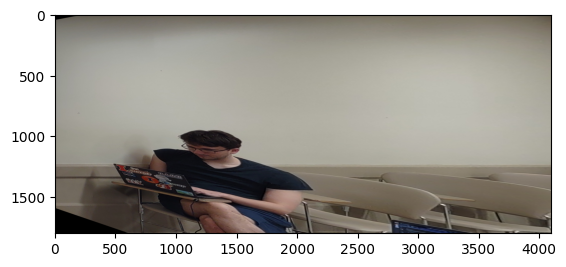

In [347]:
# Compute the Homography of the Left Side

height = int(height_image)
depth = int(depth_image)

H = computeHomography(left_box[0], left_box[1], height, depth)
print(H)


# Project onto a a flat surface

# Set the canvas
projectedWidth = depth
projectedHeight = height
Tr = np.array([[1, 0, 0],
               [0, 1, 0],
               [0, 0, 1]]).astype('float32')

# Warp the whole image onto the backgorund
projIm1 = cv2.warpPerspective(image_rgb, 
                              Tr@H, 
                              (projectedWidth, 
                               projectedHeight))
plt.figure()
plt.imshow(projIm1)

### Top (ceiling)

[[ 7.72767075e-03 -2.13520659e-02 -9.99562095e-01]
 [-1.82579646e-14  1.72408221e-02  7.90158106e-11]
 [-3.46944695e-17 -1.23190254e-05  7.92113335e-03]]


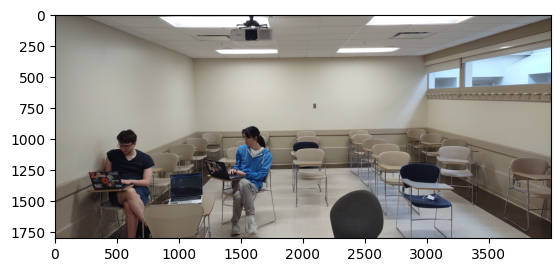

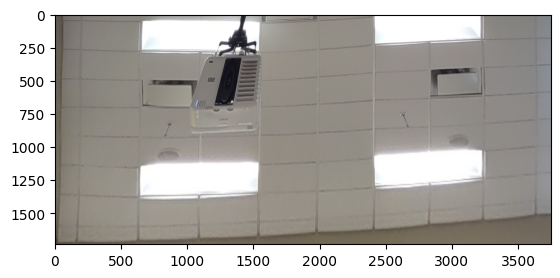

In [348]:
# Compute TOP

width = int(2 * width_box)
height = int(2 * height_box)

H = computeHomography(top_box[0], top_box[1], height, depth_image)
print(H)

plt.figure()
plt.imshow(image_rgb)


projectedWidth = width
projectedHeight = height
Tr = np.array([[1, 0, 10], [0, 1, 0], [0, 0, 1]]).astype('float32')

# TO DO: warp and blend the two images
# images location
# Load an color image in grayscale
projIm1 = cv2.warpPerspective(image_rgb, 
							  Tr@H, 
							  (projectedWidth, 
		  					   projectedHeight))
plt.figure()
plt.imshow(projIm1)

### Right wall

[[-3.26139767e-04 -4.19694068e-13  9.74179485e-01]
 [-5.21673404e-05 -1.96490924e-04  2.25774615e-01]
 [-4.20956231e-08 -2.27834922e-16  8.02342578e-05]]


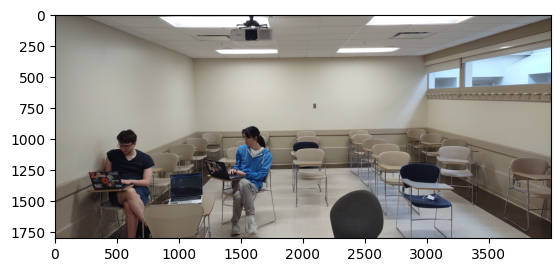

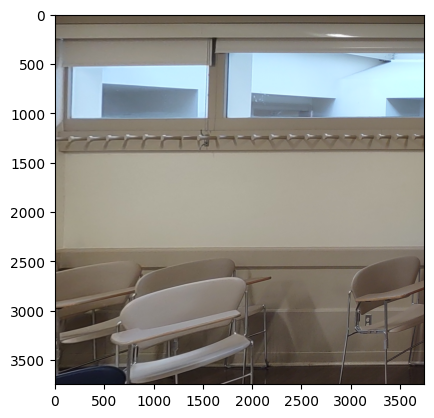

In [349]:
# Compute RIGHT

width = int(2 * width_box)
height = int(2 * height_box)

H = computeHomography(right_box[0], right_box[1], width, width)
print(H)

plt.figure()
plt.imshow(image_rgb)


projectedWidth = width
projectedHeight = width
Tr = np.array([[1, 0, 10], [0, 1, 0], [0, 0, 1]]).astype('float32')

# TO DO: warp and blend the two images
# images location
# Load an color image in grayscale
projIm1 = cv2.warpPerspective(image_rgb, 
							  Tr@H, 
							  (projectedWidth, 
		  					   projectedHeight))
plt.figure()
plt.imshow(projIm1)

### Bottom (floor)

[[-2.16979333e-04 -2.96152515e-04  6.03988675e-01]
 [ 1.87566976e-15 -6.51137695e-04  7.96992539e-01]
 [ 4.57262266e-17 -1.86729202e-07  1.20066877e-04]]


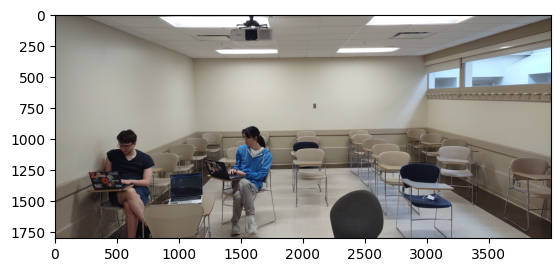

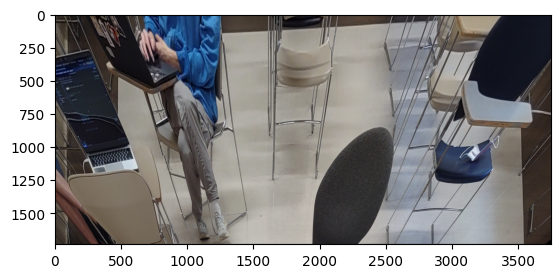

In [350]:
# Compute Left

width = int(2 * width_box)
height = int(2 * height_box)

H = computeHomography(bottom_box[0], bottom_box[1], height, width)
print(H)

plt.figure()
plt.imshow(image_rgb)


projectedWidth = width
projectedHeight = height
Tr = np.array([[1, 0, 10], [0, 1, 0], [0, 0, 1]]).astype('float32')

# TO DO: warp and blend the two images
# images location
# Load an color image in grayscale
projIm1 = cv2.warpPerspective(image_rgb, 
							  Tr@H, 
							  (projectedWidth, 
		  					   projectedHeight))
plt.figure()
plt.imshow(projIm1)